# Imports

In [1]:
import re
import nltk
import warnings
import unidecode
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords 
from sklearn.ensemble import VotingClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression

plt.style.use('ggplot')
nltk.download("stopwords")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/michalf/xview2/Taylor_pruning/.pruning/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michalf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data loading

In [2]:
train, test = pd.read_json('data/cooking_train.json').sort_values(by=['id']), pd.read_json('data/cooking_test.json')
train['num_ingr'] = train.ingredients.apply(len)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Cuisines: {len(train.cuisine.unique())}")
print(f"Unique ingredients: {len(set([j for i in train.ingredients for j in i]))}")
train.head()

Train shape: (30000, 4)
Test shape: (9774, 2)
Cuisines: 20
Unique ingredients: 6251


,cuisine,id,ingredients,num_ingr
25618,spanish,0,"[mussels, ground black pepper, garlic cloves, ...",11
22928,mexican,1,"[tomatoes, diced red onions, paprika, salt, co...",18
15512,french,2,"[chicken broth, truffles, pimentos, green pepp...",18
2624,chinese,3,"[fresh ginger, sesame oil, frozen peas, cooked...",11
10362,italian,4,"[orange peel, cookies, vanilla ice cream, gran...",4


# Data visualization

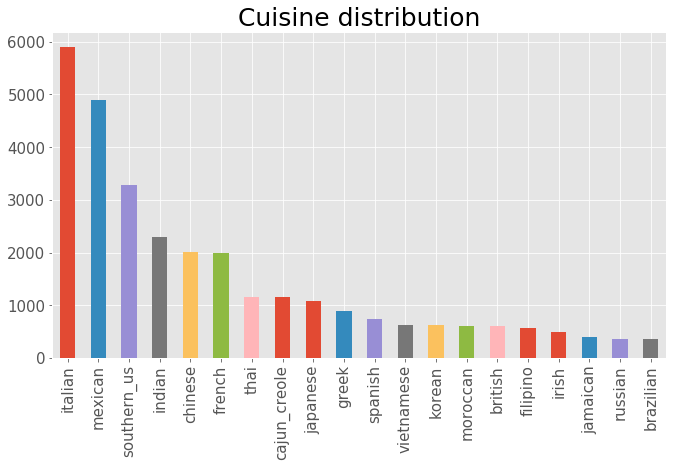

In [3]:
plt.title('Cuisine distribution', fontsize=25)
train.cuisine.value_counts().plot.bar(figsize=(11, 6), fontsize=15);

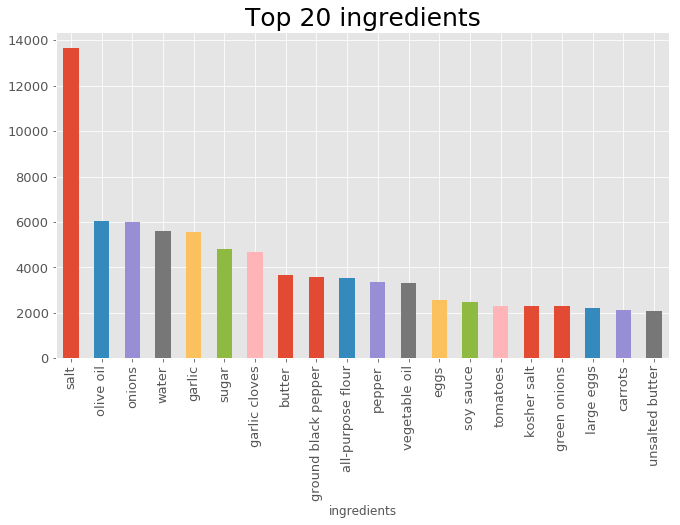

In [4]:
top = Counter([item for sublist in train.ingredients for item in sublist])
temp = pd.DataFrame(top.most_common(20), columns=['ingredients','total_count'])
temp.plot.bar(x='ingredients', y='total_count', figsize=(11, 6), fontsize=13, legend=None);
plt.title('Top 20 ingredients', fontsize=25);

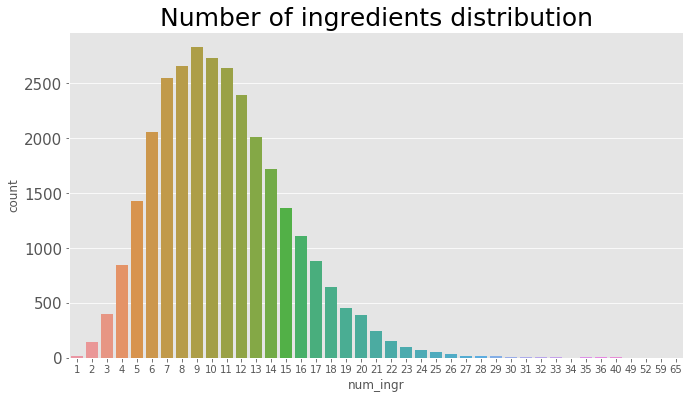

In [5]:
plt.figure(figsize=(11, 6))
plt.title('Number of ingredients distribution', fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=15)
sns.countplot(x='num_ingr', data=train);

# Feature engineering
- Converting characters to lower case 
- Removing all characters other than letters eg. 's$alt' -> 'salt'
- Removing stop words
- Removing all words of lenght 1
- Stemming words eg. 'apples' -> 'appl'
- Creating from words of recipies "polynomial" of order two eg. ['a', 'b', 'c'] -> ['a', 'b', 'c', 'a b', 'a c', 'b c']
- Removing recepies of length 1
- Using TfidfVectorizer to vectorize recipes

In [6]:
def preprocessor(line):
    # removing stop words and words of lenght 1
    text = ' '.join([word for word in line if word not in stop_words and len(word) > 1]).lower()
    # striping accents 
    text = unidecode.unidecode(text)
    # removing non letters characters
    text = re.sub('[^a-z ]', '', text).strip()
    for i in line:
        # for ingredients consisting of more than 2 words create equivalent 1 word e.g 'a b c' -> 'a-b-c'
        if len(i.split()) > 2:
            w = unidecode.unidecode(i)
            w = re.sub('[^a-z ]', '', w).strip()
            text += ' ' + '-'.join(w.split())
    return text

def tokenizer(line):
    # stemming and sorting which is neccesery for creating unequivocal polynomials 
    text = sorted(set([stemmer.stem(word) for word in line.split()]))
    # appending polynomials of order 2 
    return np.hstack([text, [f"{i} {j}" for idxi, i in enumerate(text) for idxj, j in enumerate(text)
                             if idxi < idxj and not '-' in i and not '-' in j]])

stemmer = SnowballStemmer('english')
stop_words = stopwords.words("english")
tfidf = TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer)
train = train[train['num_ingr'] > 1]

print(f"Example of preprocessing list: {['Apple', 'ORa-NGE', 'S$alt!', 'garliç çloves test', 'a']}")
tokenizer(preprocessor(['Apple', 'ORa-NGE', 'S$alt!', 'garliç çloves test', 'a']))

Example of preprocessing list: ['Apple', 'ORa-NGE', 'S$alt!', 'garliç çloves test', 'a']


array(['appl', 'clove', 'garlic', 'garlic-cloves-test', 'orang', 'salt',
       'test', 'appl clove', 'appl garlic', 'appl orang', 'appl salt',
       'appl test', 'clove garlic', 'clove orang', 'clove salt',
       'clove test', 'garlic orang', 'garlic salt', 'garlic test',
       'orang salt', 'orang test', 'salt test'], dtype='<U18')

In [7]:
%%time
X_train, y_train, X_test = tfidf.fit_transform(train.ingredients), train.cuisine, tfidf.transform(test.ingredients)

CPU times: user 25.5 s, sys: 379 ms, total: 25.9 s
Wall time: 25.9 s


#### Dimensions of X_train after transformation:

In [8]:
X_train.shape

(29980, 268085)

# Model definitions
For submission using:
1. Linear SVM
2. Voting classifier:
    - Linear SVM
    - SGD trained on modified huber loss
    - Logistic Regression

In [9]:
lsvm = LinearSVC(C=1.29, random_state=0)
sgd = SGDClassifier(loss='modified_huber', alpha=5e-5, tol=1e-6, random_state=28, n_jobs=-1)
lr = LogisticRegression(C=70, dual=True, solver='liblinear', max_iter=500, random_state=0)
voting = VotingClassifier(estimators=[('lsvm', lsvm), ('sgd', sgd), ('lr', lr)], voting='hard')

# Util functions

In [10]:
def cross_val(model, name, cv=10):
    cv_results=cross_validate(model, X_train, y_train, cv=cv, n_jobs=-1)
    print(f"{name} CV ACC = {np.mean(cv_results['test_score'])}")

def predict(model, Xtr, ytr, Xte):
    model.fit(Xtr, ytr)
    return model.predict(Xte)

def make_submit(prediction, name):
    submission = test.copy()
    submission['cuisine'] = prediction
    submission.to_csv(name, index=False, columns=['id', 'cuisine'])

# Cross-validation score
Execution of this cell may take a while.

In [11]:
%%time
cross_val(lsvm, 'LSVM')
cross_val(sgd, 'SGD')
cross_val(lr, 'LR')
cross_val(voting, 'Voting')

LSVM CV ACC = 0.814044761094379
SGD CV ACC = 0.8130101129153656
LR CV ACC = 0.8089392957200505
Voting CV ACC = 0.8128097334168839
CPU times: user 10.9 s, sys: 2.02 s, total: 12.9 s
Wall time: 8min 17s


# Creating submissions

In [12]:
%%time
make_submit(predict(lsvm, X_train, y_train, X_test), 'lsvm.csv')
make_submit(predict(voting, X_train, y_train, X_test), 'voting.csv')

CPU times: user 2min 36s, sys: 548 ms, total: 2min 37s
Wall time: 2min 23s
